In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



d:\AIDU\flower_classification


In [2]:
from libs.common import *
from config.config import *
from utils.utils import load_data, flower_labels, view_hist_data,view_images, plot_loss, plot_accuracy
from models.models import VGG16, RESNET50, InceptionV3





d:/AIDU/flower_classification


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [4]:
train_path = os.path.join(data_dir, "train.csv").replace("\\", "/")
test_path = os.path.join(data_dir, "val.csv").replace("\\", "/")
print(train_path)

d:/AIDU/flower_classification/data/train.csv


In [5]:
(x_train, y_train), (x_test, y_test)= load_data(train_path, test_path)

Read train data:  d:/AIDU/flower_classification/data/train.csv
['train/carnation/6838762136_f8254d6a1a_c.jpg'
 'train/carnation/3540544866_823aee81af_c.jpg'
 'train/carnation/50034862576_b0f55b7b3b_c.jpg' ...
 'train/common_daisy/26267498316_8ed1c153b4_c.jpg'
 'train/common_daisy/50560319813_debdfea05e_c.jpg'
 'train/common_daisy/7462259536_7f096c222f_c.jpg']
Read valid data:  d:/AIDU/flower_classification/data/val.csv


train/carnation/6838762136_f8254d6a1a_c.jpg
Training images:  13642  - shape:  (256, 256, 3)
Validating images:  98  - shape:  (256, 256, 3)


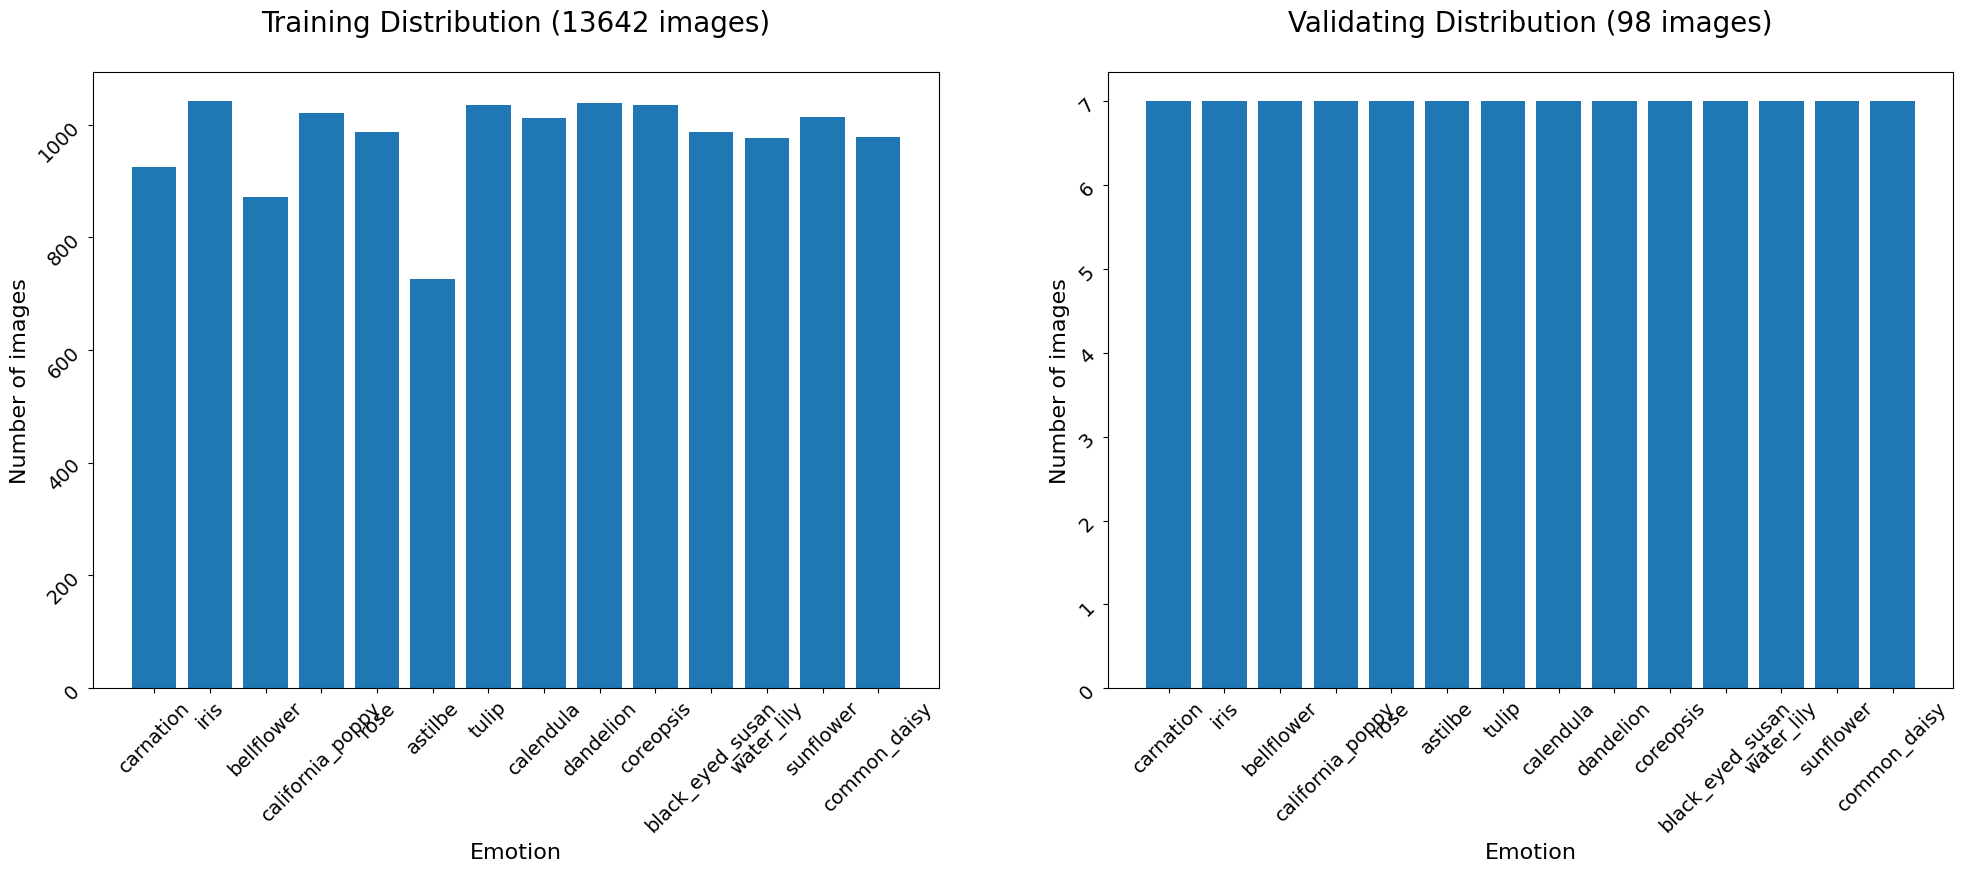

In [6]:
view_hist_data(x_train, y_train, x_test, y_test, save_path = f'{save_dir}/distribution.png')

Sample training images


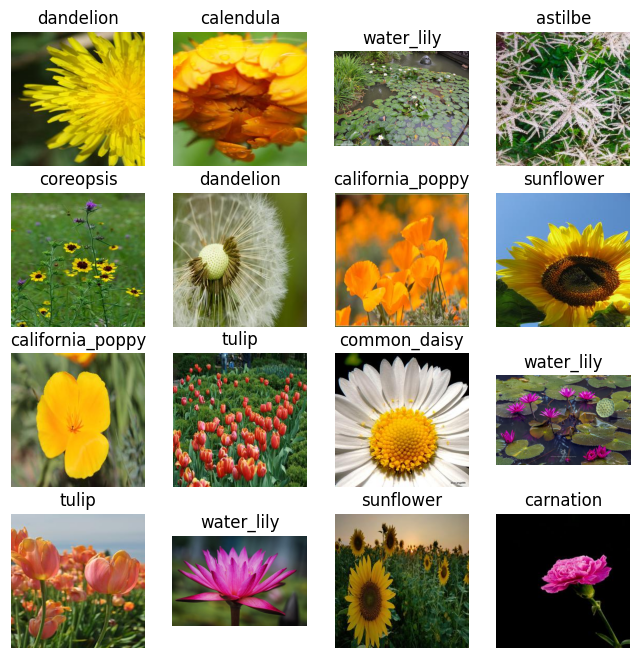

Sample Test images


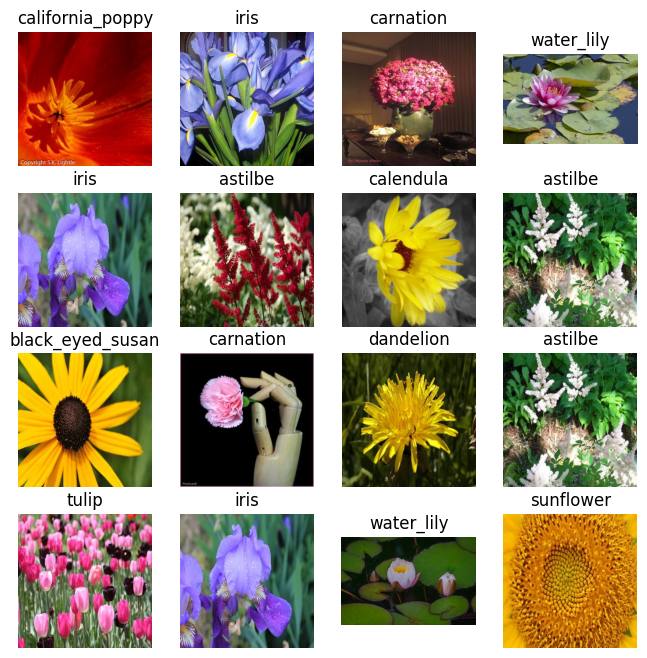

In [7]:
print("Sample training images")
view_images(x_train, y_train, None, rows = 4, cols = 4, figsize = (8, 8), 
            save_path = f'{save_dir}/sample_training_images.png')

print("Sample Test images")
view_images(x_test, y_test, None, rows = 4, cols = 4, figsize = (8, 8), 
            save_path = f'{save_dir}/sample_validating_images.png')



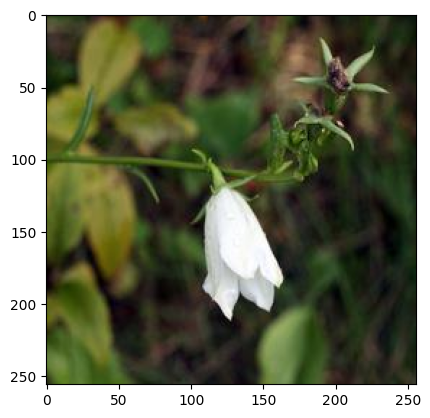

In [8]:
flow1 = cv2.imread(f'{data_dir}/train/bellflower/48917780_834f0a1ce3_c.jpg')
flow1 = cv2.cvtColor(flow1,cv2.COLOR_BGR2RGB)
plt.imshow(flow1)

In [9]:
image_gen = ImageDataGenerator(rotation_range=30, 
                               width_shift_range=0.1,
                               height_shift_range=0.1, 
                               rescale=1./255., 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               fill_mode='nearest', 
                               validation_split=0.2
                              )

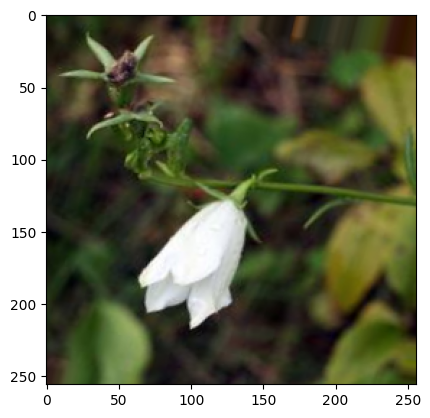

In [10]:
plt.imshow(image_gen.random_transform(flow1))

In [11]:
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(f'{data_dir}/train',
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='training')

Found 10919 images belonging to 14 classes.


In [12]:
valid_image_gen = image_gen.flow_from_directory(f'{data_dir}/train',
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='validation')

Found 2723 images belonging to 14 classes.


In [13]:
train_image_gen.class_indices

{'astilbe': 0,
 'bellflower': 1,
 'black_eyed_susan': 2,
 'calendula': 3,
 'california_poppy': 4,
 'carnation': 5,
 'common_daisy': 6,
 'coreopsis': 7,
 'dandelion': 8,
 'iris': 9,
 'rose': 10,
 'sunflower': 11,
 'tulip': 12,
 'water_lily': 13}

In [14]:
train_image_gen.classes

array([ 0,  0,  0, ..., 13, 13, 13])

In [15]:
train_steps = 100000//batch_size
valid_steps = 20000//batch_size

# input_data_resnet = batch_images  # shape: (num_samples, 224, 224, 3)
# input_data_vgg = batch_images     # shape: (num_samples, 224, 224, 3)
# target_data = batch_labels 


# valid_data_resnet=valid_images
# valid_data_vgg=valid_images
# valid_target_data =valid_labels# 

In [16]:
# print(batch_labels)

In [17]:
unique_classes = np.array(np.unique(train_image_gen.classes))
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=train_image_gen.classes)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
np.savez(f'{save_dir}/class_weights_dict.npz', class_weights_dict = class_weights_dict)
class_weights_dict

{0: 1.342389968035407,
 1: 1.1173761768317643,
 2: 0.9885026253847546,
 3: 0.9640649832244393,
 4: 0.954624934429096,
 5: 1.053957528957529,
 6: 0.9960773581463237,
 7: 0.9419427191166322,
 8: 0.9385422038851642,
 9: 0.9362888012347796,
 10: 0.9885026253847546,
 11: 0.9616875110093359,
 12: 0.9419427191166322,
 13: 0.997351114358787}

In [18]:
# !wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5
# !wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_resnet50.h5
# !wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_senet50.h5    
# !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [19]:
# !mkdir E:\\AIDU\\flower_classification\\models\\weights

In [20]:
# !move rcmalli_vggface_tf_notop_vgg16.h5 E:\\AIDU\\flower_classification\\models\\weights
# !move rcmalli_vggface_tf_notop_resnet50.h5 E:\\AIDU\\flower_classification\\models\\weights
# !move rcmalli_vggface_tf_notop_senet50.h5 E:\\AIDU\\flower_classification\\models\\weights
# !move inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 D:\\AIDU\\flower_classification\\models\\weights

In [21]:
inceptionv3_model = InceptionV3(include_top=False,input_shape=(224,224,3),pooling='avg')
inceptionv3_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [22]:
inceptionv3_model.load_weights(f"{weights_models_dir}/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")
x = inceptionv3_model.layers[-1].output
prediction_inceptionv3=Dense(14, activation='softmax',name='output2')(x)
inceptionv3_model = Model(inputs=inceptionv3_model.input, outputs=prediction_inceptionv3,name='inceptionv3')
lr=0.0001
inceptionv3_model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

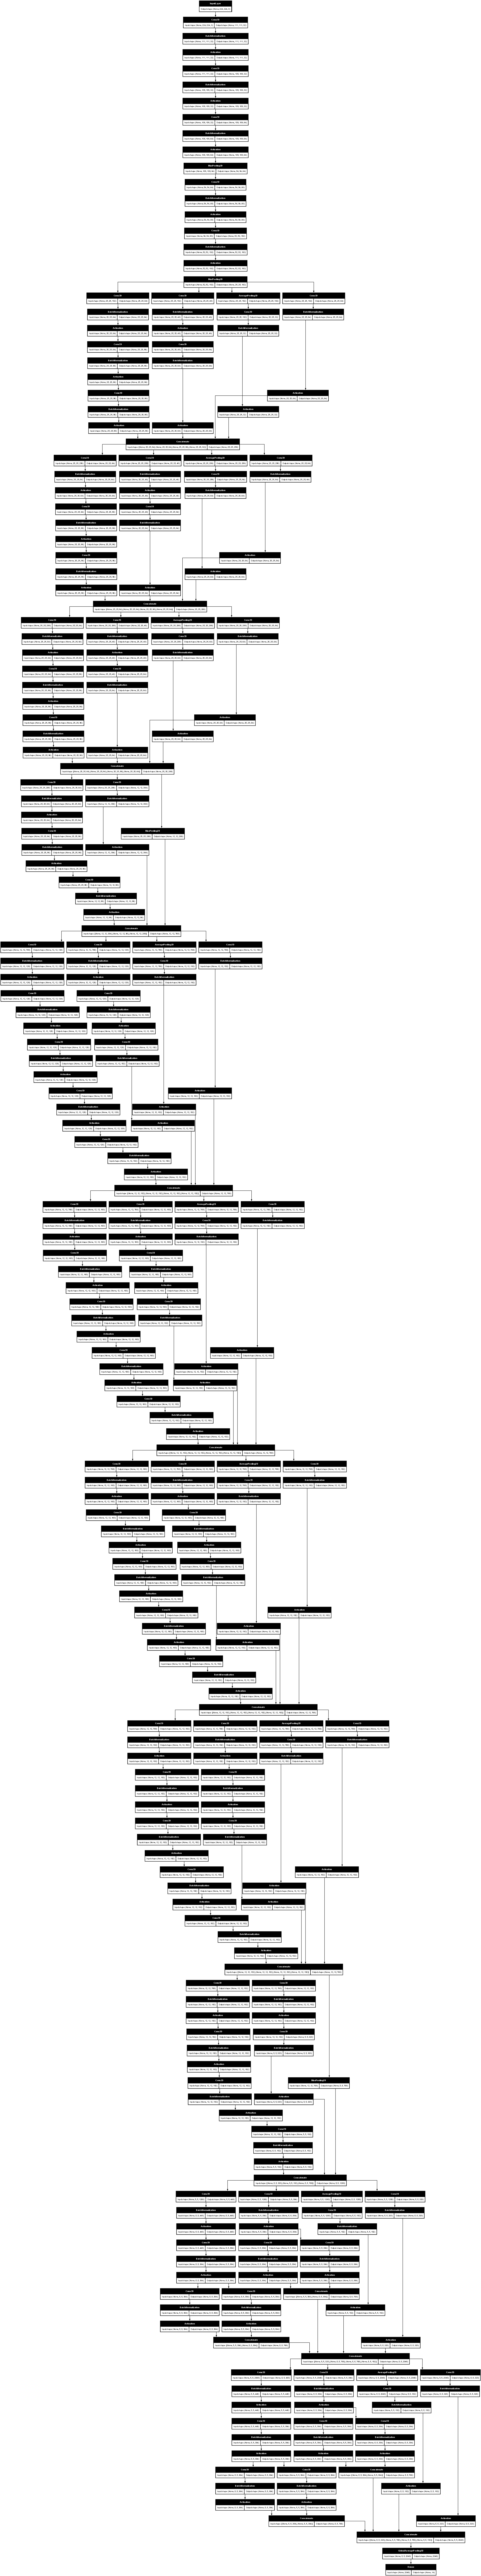

In [23]:
plot_model(inceptionv3_model, to_file="inceptionv3.png", show_shapes=True, dpi=50, expand_nested=True)


In [24]:
early_stopping = EarlyStopping(monitor='val_loss',
    # min_delta=0.00005,
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.95,
    patience=2,
    min_lr=0.000001,
    verbose=1,
)

os.makedirs('weights', exist_ok=True)

checkpoint_filepath = '/weights/checkpoint.weights.h5'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
starting_time = time.time()


In [26]:
history = inceptionv3_model.fit(
    train_image_gen,
    epochs=30,
    batch_size=64,
    validation_data=valid_image_gen,
    # validation_steps=valid_steps,
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    class_weight=class_weights_dict
)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/30


e:\User\miniconda3\envs\image_ai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.6965 - loss: 1.0390 - val_accuracy: 0.9030 - val_loss: 0.3150 - learning_rate: 1.0000e-04
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.9390 - loss: 0.1879 - val_accuracy: 0.9199 - val_loss: 0.2719 - learning_rate: 1.0000e-04
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 629s 4s/step - accuracy: 0.9640 - loss: 0.1212 - val_accuracy: 0.9210 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 602s 3s/step - accuracy: 0.9779 - loss: 0.0785 - val_accuracy: 0.9343 - val_loss: 0.2269 - learning_rate: 1.0000e-04
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 585s 3s/step - accuracy: 0.9825 - loss: 0.0599 - val_accuracy: 0.9295 - val_loss: 0.2881 - learning_rate: 1.0000e-04
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9793 - loss: 0.0634
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.499999760009814e-05.
171/171 ━━━━━━━━━━━━━━━━━━━━ 592s 3s/step - accuracy: 0.9793 - lo

In [30]:
inceptionv3_model.save('weights/model.h5')


In [31]:
acc = inceptionv3_model.history.history['accuracy']
val_acc = inceptionv3_model.history.history['val_accuracy']
loss = inceptionv3_model.history.history['loss']
val_loss = inceptionv3_model.history.history['val_loss']

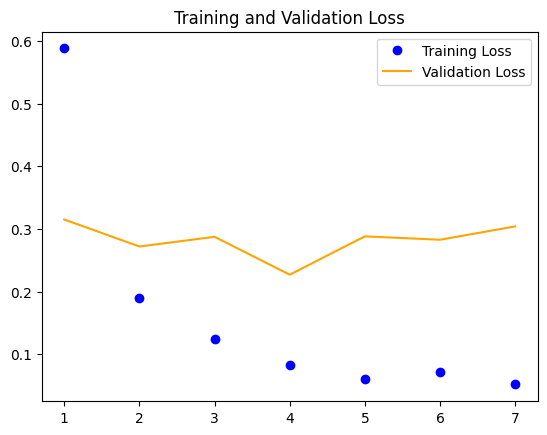

In [32]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

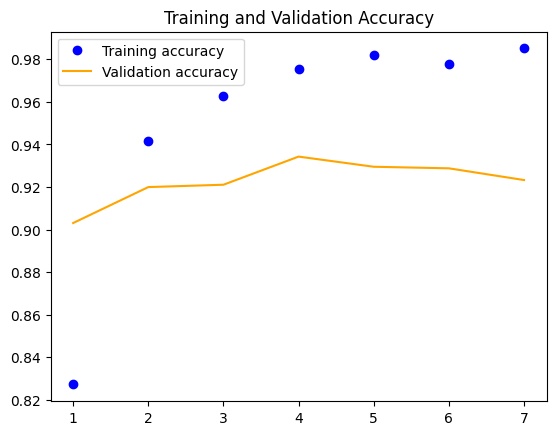

In [33]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

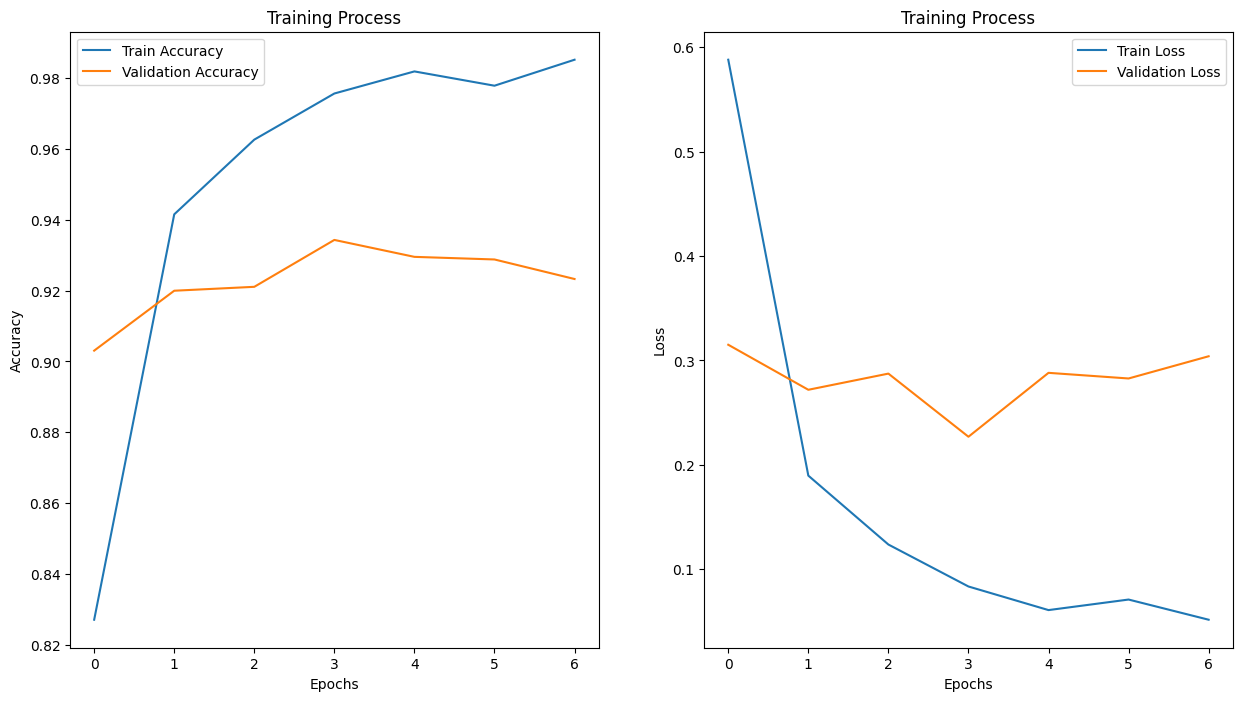

<Figure size 640x480 with 0 Axes>

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

history = inceptionv3_model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

plt.savefig('train.png')

In [35]:
image_test_data=f'{data_dir}/val'
test_datagen = ImageDataGenerator(rescale=1./255.)

test_image_gen = test_datagen.flow_from_directory(
    image_test_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 98 images belonging to 14 classes.


In [36]:
test_image_gen.class_indices

{'astilbe': 0,
 'bellflower': 1,
 'black_eyed_susan': 2,
 'calendula': 3,
 'california_poppy': 4,
 'carnation': 5,
 'common_daisy': 6,
 'coreopsis': 7,
 'dandelion': 8,
 'iris': 9,
 'rose': 10,
 'sunflower': 11,
 'tulip': 12,
 'water_lily': 13}

In [37]:
loss, acc = inceptionv3_model.evaluate(test_image_gen)
print('Test Loss:', loss)
print('Test Accuracy:', acc)


e:\User\miniconda3\envs\image_ai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step - accuracy: 0.9463 - loss: 0.1379
Test Loss: 0.1591389775276184
Test Accuracy: 0.9489796161651611


In [38]:
probability = inceptionv3_model.predict(test_image_gen)
y_pred = np.argmax(probability, axis=1)
y_test_labels = test_image_gen.classes



4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 783ms/step


In [39]:
print(y_test_labels.shape, y_pred.shape)


(98,) (98,)


In [40]:
from utils.utils import plot_confusion_matrix

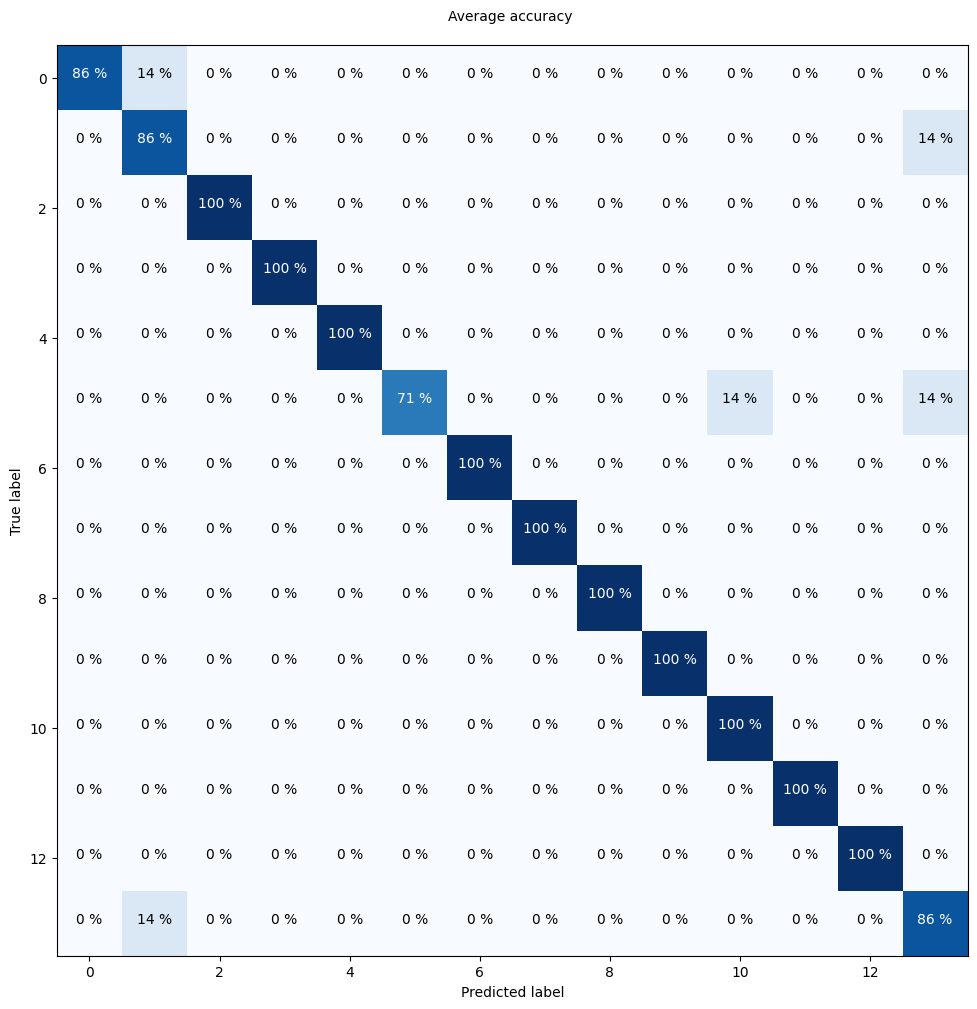

In [41]:
plot_confusion_matrix(y_test=y_test_labels,y_pred=y_pred,tick_size=10,title_size=10,axis_label_size=10, figsize=(15,10))